# T02: Bias-variance trade-off

## Let's start by recalling what we have learned in class!

## Bias–variance decomposition of squared error

When fitting a model, we want to minimize
$$\mathbb{E}_{\mathcal{D}}\left[\left(f(X)-\hat{f}(X;\mathcal{D})\right)^2\right]$$
w.r.t $\hat{f}$.

If we add and substract $\mathbb{E}_{\mathcal{D}}\left[\hat{f}(X;\mathcal{D})\right]$ inside the brackets, we have
$$
\begin{aligned}
    &\mathbb{E}_{\mathcal{D}}\left[\left(f(X)-\hat{f}(X;\mathcal{D})\right)^2\right] \\
    = &\underbrace{\left(f(X) - \mathbb{E}_{\mathcal{D}}\left[\hat{f}(X;\mathcal{D})\right]\right)^2}_{Bias^2} + \underbrace{\mathbb{E}_{\mathcal{D}}\left[\left(\mathbb{E}_{\mathcal{D}}\left[\hat{f}(X;\mathcal{D})\right] - \hat{f}(X;\mathcal{D})\right)^2\right]}_{Variance}
\end{aligned}
$$


## Two sources of error

- **Bias** from erroneous assumptions in the learning algorithm.

  High bias $\longrightarrow$ **underfitting**.
  
- **Variance** from sensitivity to small fluctuations in the training set.

  High variance $\longrightarrow$ **overfitting**.

![4 cases](cases.jpg)

## A toy example

### Problem setting

- Suppose we know the ground truth of $f(\cdot):f(x)=\sin(2\pi x)$

- Now given $\{x_n\}_{n=1}^N$, we have a set of observations $\mathcal{D}=\{(x_n,y_n)\}_{n=1}^N$ with $$y_n=f(x_n) + \epsilon_n,$$ where $\epsilon_n \stackrel{\text { i.i.d. }}{\sim} \mathcal{N}(0,1)$ is random noise.

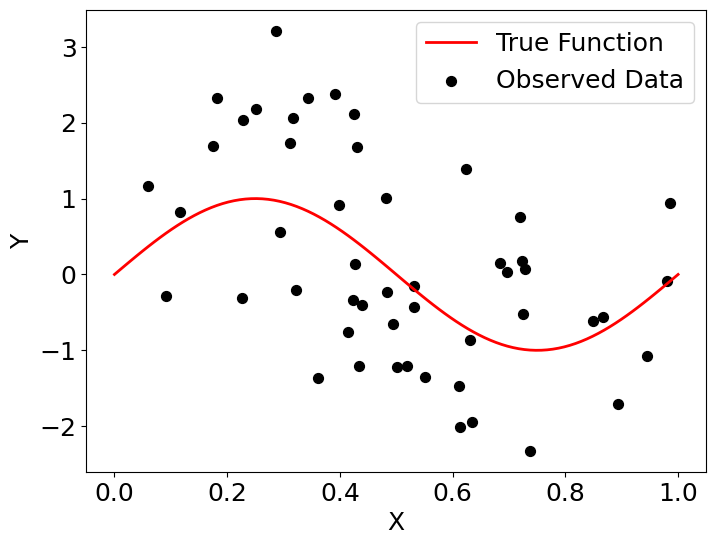

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# set a random seed
np.random.seed(123)

# Ground truth
x = np.linspace(0, 1, 100)
y = np.sin(2 * np.pi * x)

# Observed data
N = 50  # Sample size
X = np.random.uniform(0, 1, N)
y0 = np.sin(2 * np.pi * X)
y_obs = y0 + np.random.normal(0, 1, N)  # Add noise

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x, y, color='red', linewidth=2, label='True Function')
plt.scatter(X, y_obs, color='black', s=50, label='Observed Data')
plt.xlabel('X', fontsize=18)
plt.ylabel('Y', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()

For a given $\mathcal{D}$, we can fit a model $\hat{f}(X;\mathcal{D})$, e.g., linear regression.

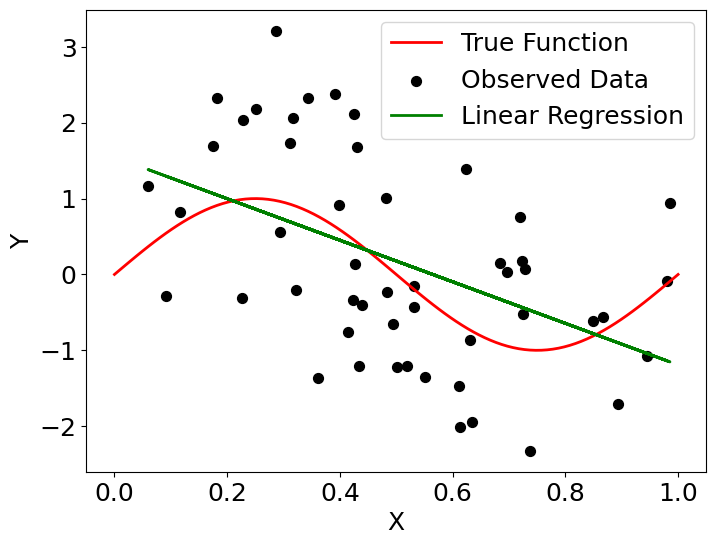

In [2]:
# Fit linear regression
from sklearn.linear_model import LinearRegression

model = LinearRegression()
X_reshaped = X.reshape(-1, 1)
model.fit(X_reshaped, y_obs)
y_pred = model.predict(X_reshaped)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x, y, color='red', linewidth=2, label='True Function')
plt.scatter(X, y_obs, color='black', s=50, label='Observed Data')
plt.plot(X, y_pred, color='green', linewidth=2, label='Linear Regression')
plt.xlabel('X', fontsize=18)
plt.ylabel('Y', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()

## Smoothing spline <sup>*</sup>

Assume $f(\cdot)$ is some unknown **smooth** function, to estimate $f(\cdot)$, a smoothing spline minimizes the penalized least squares functional
$$f_{\lambda} = \min_{f \in \mathcal{H}} \frac{1}{n} \sum_{i=1}^n \left(y_i-f\left(x_i\right)\right)^2 + \lambda J_m(f),$$
where $J_m(f)=\int\left|f^{(m)}(z)\right|^2 d z$ is a penalty term that quantifies the lack of parsimony of the function estimate, and $\lambda>0$ is the smoothing parameter that controls the influence of the penalty.

Note that $f^{(m)}(\cdot)$ denotes the $m$-th derivative of $f(\cdot)$, and $\mathcal{H}=\left\{f: J_m(f)<\infty\right\}$ is the space of functions with square integrable $m$-th derivative.

[*] See [Wikipedia](https://en.wikipedia.org/wiki/Smoothing_spline#:~:text=Smoothing%20splines%20are%20function%20estimates,means%20for%20smoothing%20noisy%20data.) or [Smoothing Spline Regression in R](http://users.stat.umn.edu/~helwig/notes/smooth-spline-notes.html) for more details if you are interested. However, this is not the point of this course!

## Smoothing parameter

- As $\lambda \rightarrow 0$ the penalty has less influence on the penalized least squares functional. So, for very small values of $\lambda$, the function estimate $f_\lambda$ essentially minimizes the residual sum of squares.

- As $\lambda \rightarrow \infty$ the penalty has more influence on the penalized least squares functional. So, for very large values of $\lambda$, the function estimate $f_\lambda$ is essentially constrained to have a zero penalty, i.e., $J_m\left(f_\lambda\right) \approx 0$.

- As $\lambda$ increases from 0 to $\infty$, the function estimate $f_\lambda$ is forced to be smoother with respect to the penalty functional $J_m(\cdot)$. The goal is to find the $\lambda$ that produces the "correct" degree of smoothness for the function estimate.

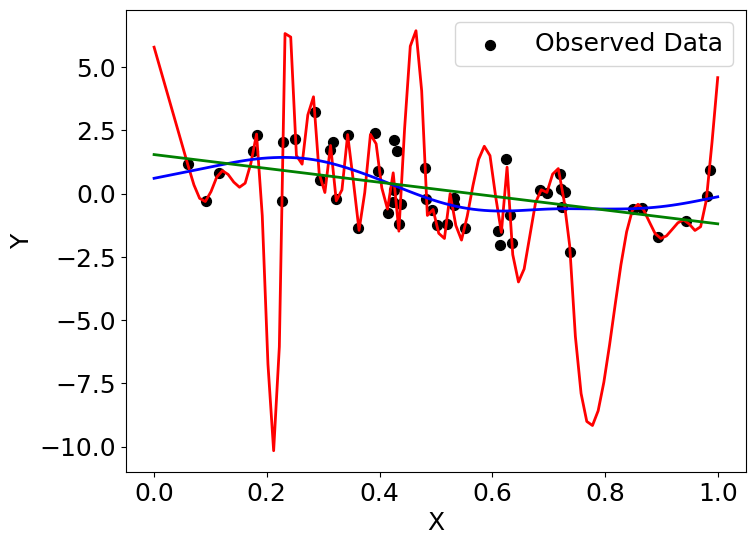

In [3]:
import rpy2.robjects as robjects
r_y = robjects.FloatVector(y_obs)
r_x = robjects.FloatVector(X)

r_smooth_spline = robjects.r['smooth.spline'] #extract R function# run smoothing function
spline1 = r_smooth_spline(x=r_x, y=r_y, spar=0.01)
spline2 = r_smooth_spline(x=r_x, y=r_y, cv=True)
spline3 = r_smooth_spline(x=r_x, y=r_y, spar=2)
ySpline1 = np.array(robjects.r['predict'](spline1,robjects.FloatVector(sorted(x))).rx2('y'))
ySpline2 = np.array(robjects.r['predict'](spline2,robjects.FloatVector(sorted(x))).rx2('y'))
ySpline3 = np.array(robjects.r['predict'](spline3,robjects.FloatVector(sorted(x))).rx2('y'))

plt.figure(figsize=(8, 6))
plt.scatter(X, y_obs, color='black', s=50, label='Observed Data')
plt.plot(sorted(x),ySpline1, color = 'red', linewidth=2)
plt.plot(sorted(x),ySpline2, color = 'blue', linewidth=2)
plt.plot(sorted(x),ySpline3, color = 'green', linewidth=2)
plt.xlabel('X', fontsize=18)
plt.ylabel('Y', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()

## How do we evaluate the bias-variance trade-off in this example?

We need $\mathbb{E}_{\mathcal{D}}(\hat{f}(X;\mathcal{D}))$, therefore, we need to have multiple datasets.

- For $l=1,...,L$,
    - generate $\mathcal{D}^l=\{(x_n,y^l_n)\}_{n=1}^N$, where $y^l_n=f(x_n) + \epsilon^l_n$
    - fit the $l$-th model $\hat{f}(X^l;\mathcal{D}^l)$ and denote the predicted value as $y^l(x_n)=\hat{f}(x_n;\mathcal{D}^l)$
    
  **Note that $f(x_n)$ is fixed across $l$ while the observed values $y^l_n$ are varying due to random noise $\epsilon_n^l$.**

- Estimate $\mathbb{E}_{\mathcal{D}}[\hat{f}(X;\mathcal{D})]$ by $\bar{y}(x)=\frac{1}{L}\sum_{l=1}^Ly^l(x)$

- Compute squared bias: $\frac{1}{N}\sum_{n=1}^N \left( \bar{y}(x_n)-f(x_n) \right)^2$

- Compute variance: $\frac{1}{N}\sum_{n=1}^N\frac{1}{L}\sum_{l=1}^L \left( y^l(x_n)-\bar{y}(x_n) \right)^2$

## Experiments

We take the above example with $N = 20$, $L = 500$ and use smoothing spline regression with $\lambda \in [1 \times 10^{-6}, 10]$.

In [4]:
# Set a random seed
np.random.seed(123)

trial = 500  # Number of experiment trials
N = 20  # Number of samples for each trial
lambda_list = np.exp(np.linspace(np.log(1e-6), np.log(10), 100))  # Parameter list
model_list = []  # Model list
biasSQ = np.zeros(len(lambda_list))  # Bias square
variance = np.zeros(len(lambda_list))  # Variance

X = np.random.uniform(0, 1, N)  # Predictor
y0 = np.sin(2 * np.pi * X)  # True values of y
y_mat = np.zeros((N, trial))  # Store the generated response variables

for j in range(trial):
    y_mat[:, j] = y0 + np.random.normal(0, 1, N)  # Add noise

r_x = robjects.FloatVector(X)
for i, lam in enumerate(lambda_list):
    model_list_i = []
    y_hat = np.zeros((N, trial))  # Predicted values
    for j in range(trial):
        r_y = robjects.FloatVector(y_mat[:, j])
        
        r_smooth_spline = robjects.r['smooth.spline'] #extract R function# run smoothing function
        kwargs = {"x": r_x, "y": r_y, "lambda": float(lambda_list[i])}
        spline1 = r_smooth_spline(**kwargs)
        ySpline1 = np.array(robjects.r['predict'](spline1,robjects.FloatVector(X)).rx2('y'))

        model_list_i.append(spline1)
        y_hat[:, j] = ySpline1
    
    model_list.append(model_list_i)
    y_bar = np.mean(y_hat, axis=1)  # Mean of predicted values
    biasSQ[i] = np.mean((y0 - y_bar) ** 2)  # Bias square
    variance[i] = np.mean((y_hat - y_bar[:, None]) ** 2)  # Variance

Let's first take a look at how the two sources of error change as the parameter $\lambda$ changes.

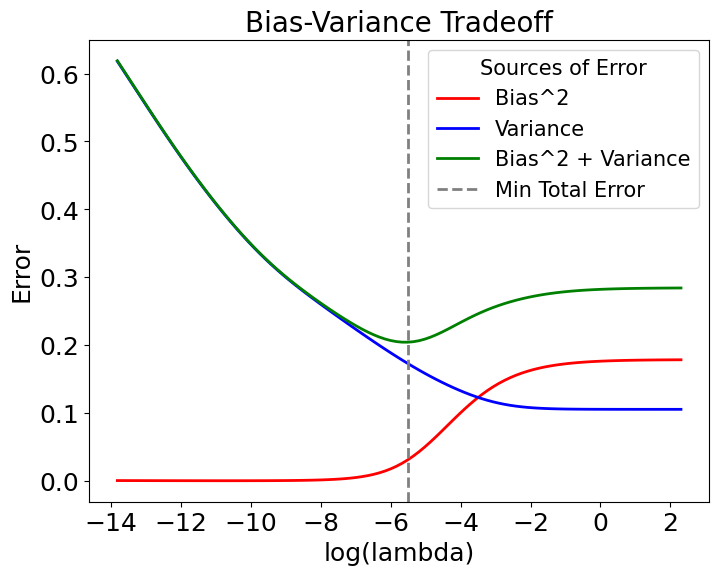

In [5]:
# Plot
import math

plt.figure(figsize=(8, 6))

plt.plot(np.log(lambda_list), biasSQ, label='Bias^2', color='red', linewidth=2)
plt.plot(np.log(lambda_list), variance, label='Variance', color='blue', linewidth=2)
plt.plot(np.log(lambda_list), biasSQ + variance, label='Bias^2 + Variance', color='green', linewidth=2)

plt.axvline(np.log(lambda_list)[np.argmin(biasSQ + variance)], color='gray', linestyle='--', linewidth=2, label='Min Total Error')

plt.xlabel('log(lambda)', fontsize=18)
plt.ylabel('Error', fontsize=18)
plt.title('Bias-Variance Tradeoff', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(title='Sources of Error', fontsize=15, title_fontsize=15, loc='upper right')
plt.show()

## More details

Then we chose three different values for the parameter $\lambda$ (too small, suitable, too large) and visualize for more performance details.

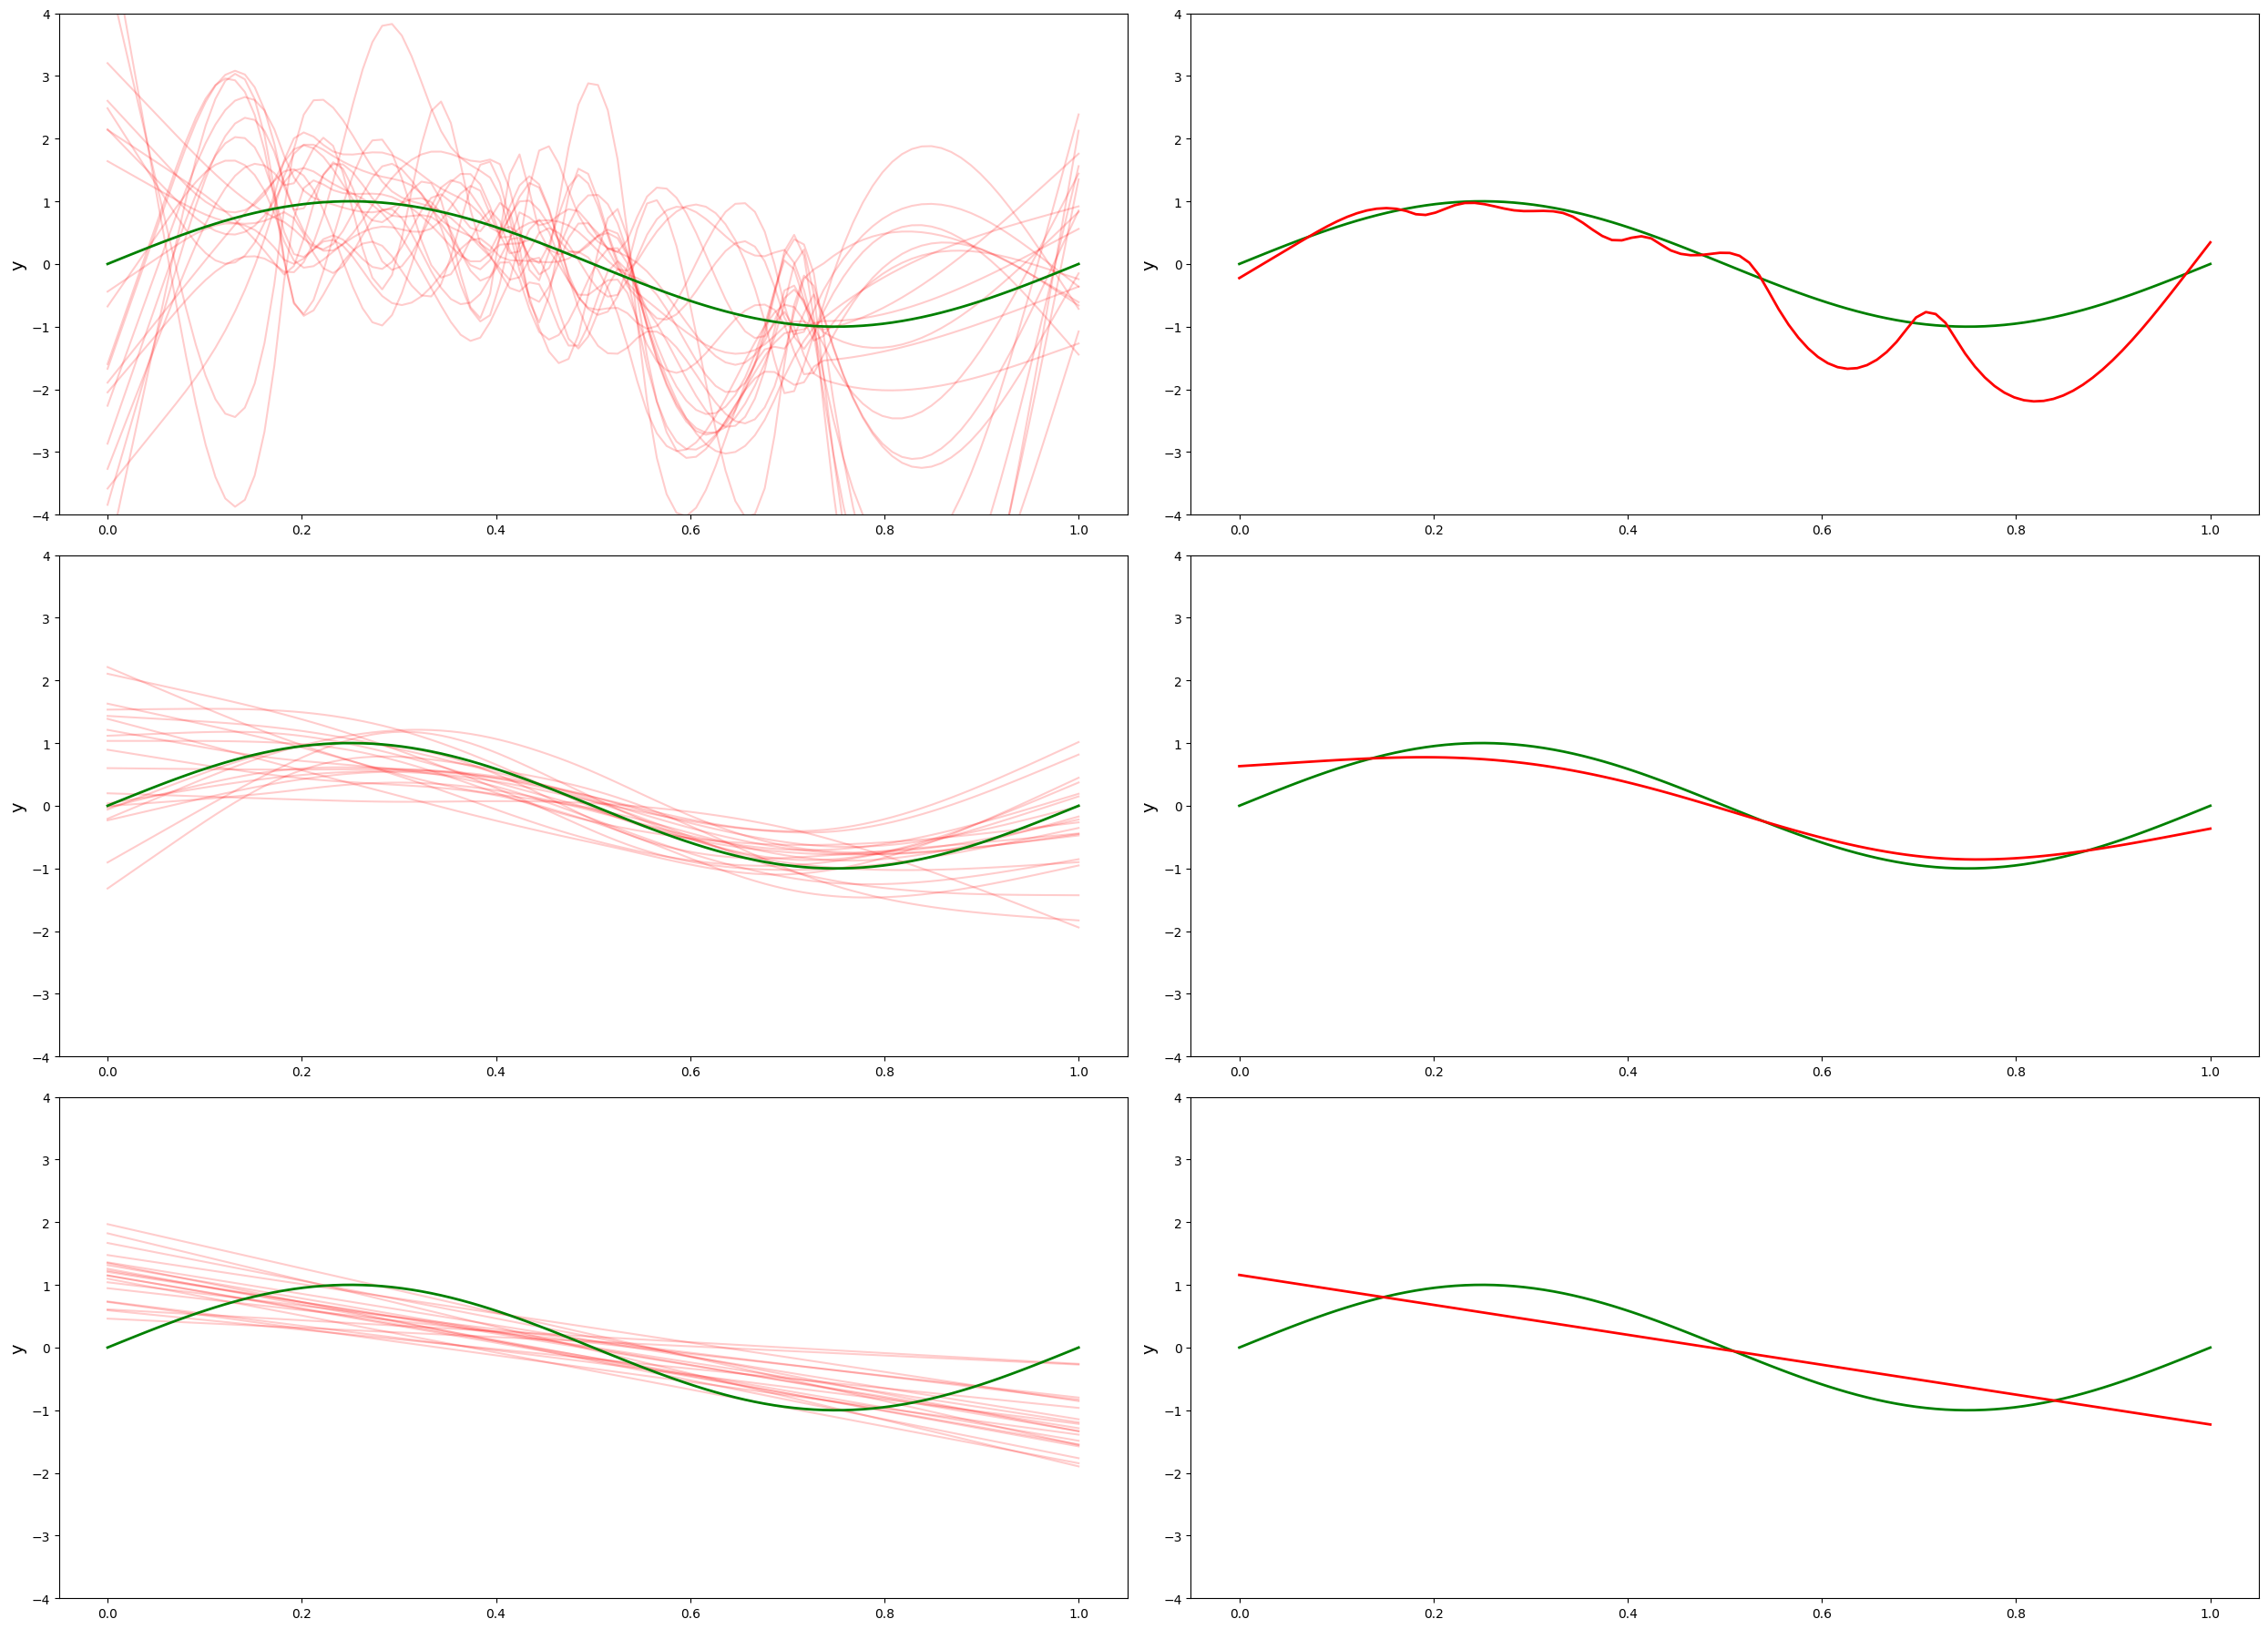

In [6]:
N = 100
x = np.linspace(0, 1, N)
y0 = np.sin(2 * np.pi * x)

lambda_idx_list = [0, np.argmin(biasSQ + variance), len(lambda_list) - 1]

# Plot
fig, axes = plt.subplots(3, 2, figsize=(25, 18))
for idx, lambda_idx in enumerate(lambda_idx_list):
    y_hat = np.zeros((N, 20))
    for j in range(20):
        # predict using save models
        spline_model = model_list[lambda_idx][j]
        y_hat[:, j] = np.array(robjects.r['predict'](spline_model,robjects.FloatVector(x)).rx2('y'))
        
        # plot predictions for each model
        axes[idx, 0].plot(x, y_hat[:, j], color='red', alpha=0.2)
    
    # plot ground truth
    axes[idx, 0].plot(x, y0, color='green', linewidth=2)
    axes[idx, 0].set_ylim(-4, 4)
    axes[idx, 0].set_ylabel('y', fontsize=14)
    
    # plot average prediction
    mean_prediction = np.mean(y_hat, axis=1)
    axes[idx, 1].plot(x, y0, color='green', linewidth=2)
    axes[idx, 1].plot(x, mean_prediction, color='red', linewidth=2)
    axes[idx, 1].set_ylim(-4, 4)
    axes[idx, 1].set_ylabel('y', fontsize=14)

plt.tight_layout()
plt.show()